# Import des librairies

In [1]:
#Main libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Embeddings

from sentence_transformers import util, SentenceTransformer

In [3]:
#deep learning

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau

In [4]:
#Classifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [5]:
#Model selection

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from IPython.display import display

# Import des données

In [6]:
data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [7]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
data.shape

(7613, 5)

In [9]:
data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Split training data and validation data

In [10]:
train_data, val_data = train_test_split(data, test_size=0.1)

In [11]:
train_data.shape

(6851, 5)

In [12]:
val_data.shape

(762, 5)

### Resetting index

In [13]:
train_data.reset_index(drop=True, inplace=True)

In [14]:
train_data.head()

,id,keyword,location,text,target
0,1289,bloody,NaN,'A Nightmare On Elm Street' Is Getting Remade....,0
1,438,apocalypse,Las Vegas,I know where to go when the zombies take over!...,0
2,8356,ruin,Garrett,like why on earth would you want anybody to be...,0
3,1661,bombing,NaN,Today is the day Hiroshima got Atomic bomb 70 ...,1
4,4537,emergency,Southern Maine,Former heroin addict shares story as city lead...,1


In [15]:
val_data.reset_index(drop=True, inplace=True)

### Separating X and target

In [16]:
X_train = train_data['text']

In [17]:
y_train = train_data['target']

In [18]:
X_val = val_data['text']

In [19]:
y_val = val_data['target']

# Data Engineering

In [20]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [21]:
data.keyword.isna().sum()

61

In [22]:
data.location.isna().sum()

2533

In [23]:
l_full_text = []

for i in range(data.shape[0]):
    full_text = data['text'][i]
    if str(data['keyword'][i]) != 'nan':
        full_text += f' #{data["keyword"][i]}'
    if str(data['location'][i]) != 'nan':
        full_text += f' #{data["location"][i]}'

    l_full_text.append(full_text)

In [24]:
data['full_text'] = pd.Series(l_full_text)

In [25]:
data.head()

,id,keyword,location,text,target,full_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...


Après quelques essais, les embeddings de full_text offrent de moins bons résultats de prédiction que ceux du texte simple.

# Sentence Embeddings

In [26]:
transformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [27]:
embeddings = transformer.encode(X_train)

In [28]:
embeddings.shape

(6851, 768)

In [29]:
val_embeddings = transformer.encode(X_val)

# Deep Learning Model

### Convert embeddings and target to tensors

In [30]:
tensor_embeddings = tf.convert_to_tensor(embeddings)
tensor_y = tf.convert_to_tensor(y_train)

Metal device set to: Apple M1


2022-08-29 12:17:40.111383: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-29 12:17:40.111634: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [31]:
tensor_embeddings.shape

TensorShape([6851, 768])

In [32]:
tensor_y.shape

TensorShape([6851])

In [33]:
tensor_val_embeddings = tf.convert_to_tensor(val_embeddings)
tensor_val_y = tf.convert_to_tensor(y_val)

### Define model architecture

In [34]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [35]:
optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)

In [52]:
model = Sequential()

# Define model architecture.
model.add(Dense(728, input_shape=(768,), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              787456    
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               262400    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [53]:
model.compile(
    optimizer=optimizer, #or optimizer
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

### Training and performances visualization

In [54]:
history = model.fit(
    x=tensor_embeddings,
    y=tensor_y,
    validation_data=(tensor_val_embeddings, tensor_val_y),
    callbacks=[learning_rate_reduction],
    epochs = 20)

Epoch 1/20


2022-08-29 17:26:12.994844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 2s 9ms/step - loss: 0.6878 - accuracy: 0.6050 - val_loss: 0.6827 - val_accuracy: 0.6864 - lr: 1.0000e-05
Epoch 2/20
  1/215 [..............................] - ETA: 1s - loss: 0.6880 - accuracy: 0.6562

2022-08-29 17:26:14.978763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 2s 7ms/step - loss: 0.6762 - accuracy: 0.6884 - val_loss: 0.6692 - val_accuracy: 0.7270 - lr: 1.0000e-05
Epoch 3/20
215/215 [==============================] - 2s 7ms/step - loss: 0.6584 - accuracy: 0.7285 - val_loss: 0.6485 - val_accuracy: 0.7979 - lr: 1.0000e-05
Epoch 4/20
215/215 [==============================] - 2s 8ms/step - loss: 0.6341 - accuracy: 0.7685 - val_loss: 0.6205 - val_accuracy: 0.8084 - lr: 1.0000e-05
Epoch 5/20
215/215 [==============================] - 2s 8ms/step - loss: 0.6044 - accuracy: 0.7872 - val_loss: 0.5862 - val_accuracy: 0.8136 - lr: 1.0000e-05
Epoch 6/20
215/215 [==============================] - 2s 8ms/step - loss: 0.5679 - accuracy: 0.8054 - val_loss: 0.5486 - val_accuracy: 0.8228 - lr: 1.0000e-05
Epoch 7/20
215/215 [==============================] - 2s 8ms/step - loss: 0.5340 - accuracy: 0.8117 - val_loss: 0.5147 - val_accuracy: 0.8241 - lr: 1.0000e-05
Epoch 8/20
215/215 [==============================] - 2s 

In [40]:
def plot_training_results(history, model_name):
    
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    
    epochs_nb = history.params['epochs']
    
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.set_title(f'Loss history of {model_name} over {epochs_nb} epochs')
    ax_loss.set_xlabel('Number of epochs')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()
    
    ax_acc.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
    ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax_acc.set_title(f'Accuracy history of {model_name} over {epochs_nb} epochs')
    ax_acc.set_xlabel('Number of epochs')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.legend()

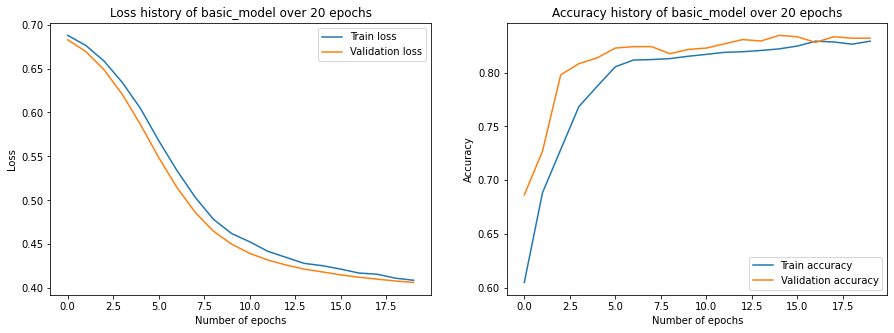

In [55]:
plot_training_results(history, 'basic_model')

# Classifier approaches 

### RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(verbose=1)

In [ ]:
rfc.fit(embeddings, y_train)

In [ ]:
rfc.score(embeddings, y_train)

In [ ]:
rfc.score(val_embeddings, y_val)

### GradientBoostingClassifier

In [ ]:
gbc = GradientBoostingClassifier(verbose=1)

In [ ]:
gbc.fit(embeddings, y_train)

In [ ]:
gbc.score(embeddings, y_train)

In [ ]:
gbc.score(val_embeddings, y_val)

# Hyperparameters tuning

In [ ]:
param_grid = { 'n_estimators': [100, 300, 500, 1000],
               'max_depth': [300, 500, 1000]
              }

In [ ]:
grid = GridSearchCV(RandomForestClassifier(verbose=1), param_grid, verbose=2)

grid.fit(embeddings, y_train)

In [ ]:
grid.best_params_

In [ ]:
grid.best_estimator_.score(val_embeddings, y_val)

In [ ]:
grid = GridSearchCV(GradientBoostingClassifier(verbose=1), param_grid, verbose=2)

grid.fit(embeddings, y_train)

In [ ]:
grid.best_params_

In [ ]:
grid.best_estimator_.score(val_embeddings, y_val)

In [ ]:
# TO DO : HALVING GRID SEARCH (version optimisée beaucoup plus rapide)

# Classifier sentence transformer (BERT ?)